In [10]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import yaml
import os

# Load configuration
with open('../../config.yaml', 'r') as file:
    config = yaml.safe_load(file)

def resolve_path(relative_path):
    return os.path.join(config['base_path'], relative_path)

african_isos = [
    'DZA', 'AGO', 'BEN', 'BWA', 'BFA', 'BDI', 'CPV', 'CMR', 'CAF', 'TCD', 'COM', 'COD', 'DJI', 'EGY', 'GNQ', 'ERI', 
    'SWZ', 'ETH', 'GAB', 'GMB', 'GHA', 'GIN', 'GNB', 'CIV', 'KEN', 'LSO', 'LBR', 'LBY', 'MDG', 'MWI', 'MLI', 'MRT', 
    'MUS', 'MAR', 'MOZ', 'NAM', 'NER', 'NGA', 'RWA', 'STP', 'SEN', 'SYC', 'SLE', 'SOM', 'ZAF', 'SSD', 'SDN', 'TZA', 
    'TGO', 'UGA', 'ZMB', 'ZWE'
]

ssa_iso = ['AGO', 'BEN', 'BWA', 'BFA', 'BDI', 'CPV', 'CMR', 'CAF', 'TCD', 'COM',
           'COG', 'COD', 'CIV', 'DJI', 'GNQ', 'ERI', 'SWZ', 'ETH', 'GAB', 'GMB',
           'GHA', 'GIN', 'GNB', 'KEN', 'LSO', 'LBR', 'MDG', 'MWI', 'MLI', 'MRT',
           'MUS', 'MOZ', 'NAM', 'NER', 'NGA', 'RWA', 'STP', 'SEN', 'SYC', 'SLE',
           'SOM', 'ZAF', 'SSD', 'SDN', 'TZA', 'TGO', 'UGA', 'ZMB', 'ZWE']

##### Filter the dam data

In [11]:
global_dams = pd.read_csv(resolve_path(config['Global_Dam_Data_csv_path']))
#print(global_dams.head())

# Strip whitespace from ISO column just in case
global_dams['ISO'] = global_dams['ISO'].str.strip()

#print(global_dams.head())

# Filter for (SSA) African dams
africa_dams = global_dams[global_dams['ISO'].isin(ssa_iso)].copy()

#print(africa_dams.head())

# Filter and keep only the necessary columns
filtered_data = africa_dams[['Country', 'Purpose', 'ISO', 'Long__res_', 'Lat__res_']]

#filtered_data.columns = filtered_data.columns.str.strip()

# Ensure Long__res_ and Lat__res_ are treated as numeric using .loc
filtered_data.loc[:, 'Long__res_'] = pd.to_numeric(filtered_data['Long__res_'], errors='coerce')
filtered_data.loc[:, 'Lat__res_'] = pd.to_numeric(filtered_data['Lat__res_'], errors='coerce')

# Exclude rows where both 'Long__res_' and 'Lat__res_' are 0
filtered_data = filtered_data[(filtered_data['Long__res_'] != 0) | (filtered_data['Lat__res_'] != 0)].copy()

filtered_data.to_csv(resolve_path(config['Africa_Dam_csv_path']), index = False)


# Filter dams where the 'Purpose' column contains the word 'Irrigation'
filtered_data_irrigation = filtered_data[filtered_data['Purpose'].str.contains('Irrigation', case=False, na=False)]

print(filtered_data_irrigation.head())

filtered_data_irrigation.to_csv(resolve_path(config['Africa_Dam_Irrigation_csv_path']), index = False)


# Filter dams where the 'Purpose' =='Irrigation'
filtered_data_irrigation_only = filtered_data[filtered_data['Purpose'] == 'Irrigation']

print(filtered_data_irrigation_only.head())

filtered_data_irrigation_only.to_csv(resolve_path(config['Africa_Dam_Irrigation_Only_csv_path']), index = False)

          Country                 Purpose  ISO Long__res_  Lat__res_
321      Zimbabwe  Hydropower, Irrigation  ZWE    32.0167     -19.25
323          Togo  Irrigation, Hydropower  BEN   1.435166   7.431467
324    Mozambique  Hydropower; Irrigation  MOZ  32.143353 -23.872949
415   Ivory Coast              Irrigation  CIV  -5.259304   9.565742
426  South Africa              Irrigation  ZAF  20.405208 -33.393856
          Country     Purpose  ISO Long__res_  Lat__res_
415   Ivory Coast  Irrigation  CIV  -5.259304   9.565742
426  South Africa  Irrigation  ZAF  20.405208 -33.393856
428  Burkina Faso  Irrigation  BFA  -5.356683  10.590938
434  South Africa  Irrigation  ZAF  22.585419 -33.512207
445  South Africa  Irrigation  ZAF   20.37198 -33.860692


Turn the CSV into a GDF and trim to arid regions

Semi_Arid CRS: EPSG:4326


/tmp/ipykernel_244479/3091390244.py:27: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_dams_layer.to_file(output_path)


✅ Saved Semi_Arid layer to: /home/waves/data/Africa_Irrigation/Data/Processed/Africa_Dam_Aridity_Layers-shp/Africa_Dam_Semi_Arid.shp


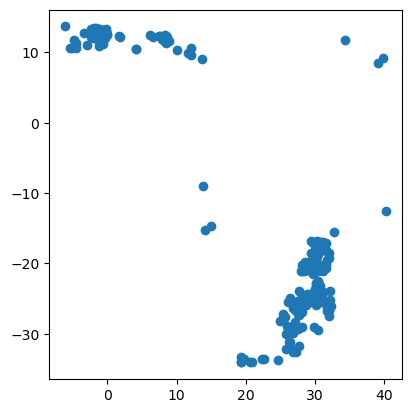

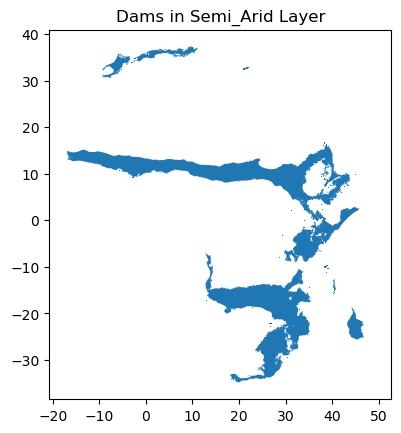

Arid CRS: EPSG:4326


/tmp/ipykernel_244479/3091390244.py:27: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_dams_layer.to_file(output_path)


✅ Saved Arid layer to: /home/waves/data/Africa_Irrigation/Data/Processed/Africa_Dam_Aridity_Layers-shp/Africa_Dam_Arid.shp


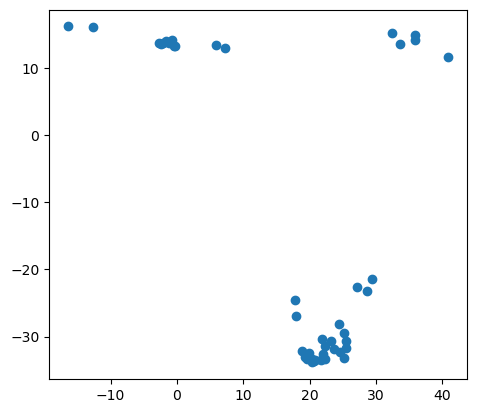

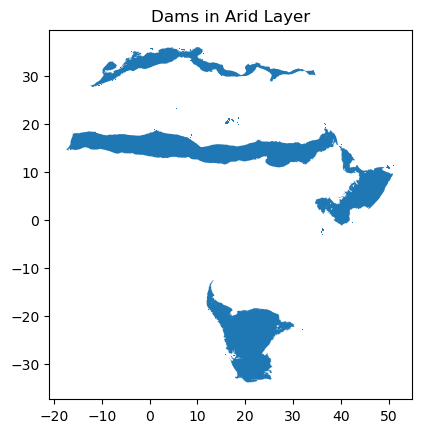

Hyper_Arid CRS: EPSG:4326
⚠️ Hyper_Arid is empty after spatial join. Skipping save.
All CRS: EPSG:4326


/tmp/ipykernel_244479/3091390244.py:27: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf_dams_layer.to_file(output_path)


✅ Saved All layer to: /home/waves/data/Africa_Irrigation/Data/Processed/Africa_Dam_Aridity_Layers-shp/Africa_Dam_All_Arid.shp


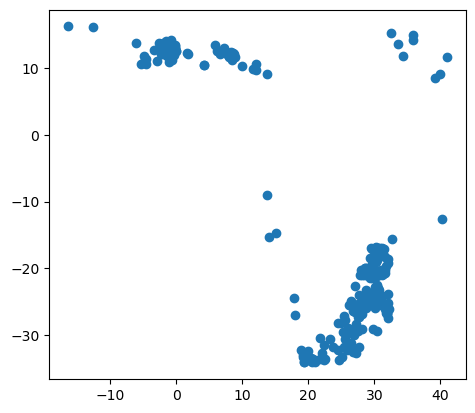

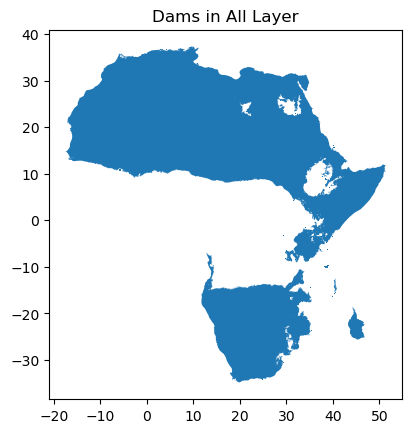

In [ ]:
# Load the dams data and convert to GeoDataFrame
africa_dams = pd.read_csv(resolve_path(config['Africa_Dam_Irrigation_csv_path']))
geometry = [Point(xy) for xy in zip(africa_dams['Long__res_'], africa_dams['Lat__res_'])]
gdf_dams = gpd.GeoDataFrame(africa_dams, geometry=geometry)
gdf_dams = gdf_dams.set_crs("EPSG:4326")  # Ensure the initial CRS is correct

# Define the aridity layers
layers = ['Semi_Arid', 'Arid', 'Hyper_Arid', 'All']

# Iterate through each aridity layer, load the shapefile, perform the spatial join, and save the result
for layer in layers:
    # Load the aridity shapefile and set CRS
    shapefile_path = resolve_path(config[f'Africa_{layer}_shp_path'])
    arid_shp = gpd.read_file(shapefile_path)
    arid_shp = arid_shp.set_crs("EPSG:4326")  # Ensure the CRS is correct
    print(f"{layer} CRS: {arid_shp.crs}")

    # Perform spatial join to crop dams to the aridity layer
    gdf_dams_layer = gpd.sjoin(gdf_dams, arid_shp, how="inner", predicate="intersects")

    # Save the cropped dams GeoDataFrame to a shapefile
    output_path = resolve_path(config[f'Africa_Dam_{layer}_shp_path'])
    
    if gdf_dams_layer.empty:
        print(f"{layer} is empty after spatial join. Skipping save.")
    else:
        gdf_dams_layer.to_file(output_path)
        print(f"Saved {layer} layer to: {output_path}")
        gdf_dams_layer.plot()
        plt.title(f'Dams in {layer} Layer')
        plt.show()

    

    